In [1]:
# This notebook illustrates the halfar ice model

# Import funman related code
import os
from funman.api.run import Runner
from funman_demo import summarize_results
from funman_demo.example.pde import plot_spatial_timeseries
from IPython.display import HTML

RESOURCES = os.path.join(
   os.getcwd(), "../resources"
)
EXAMPLE_DIR = os.path.join(RESOURCES, "amr", "halfar")

[20.00000, 20.00000) has equal lower and upper bounds, so assuming the upper bound is closed.  (I.e., [lb, ub) is actually [lb, ub])
2023-12-29 16:25:17,211 - funman.scenario.scenario - WARNING - Warning: The scenario is not normalized!
2023-12-29 16:25:19,380 - funman.api.run - INFO - Dumping results to ./out/0e140512-2416-4ef9-9162-7fdbbf4e44cb.json
2023-12-29 16:25:26,583 - funman.search.box_search - INFO - progress: 0.05000
2023-12-29 16:25:26,788 - funman.search.box_search - INFO - progress: 0.10000
2023-12-29 16:25:27,002 - funman.search.box_search - INFO - progress: 0.15000
2023-12-29 16:25:27,224 - funman.search.box_search - INFO - progress: 0.20000
2023-12-29 16:25:27,460 - funman.search.box_search - INFO - progress: 0.25000
2023-12-29 16:25:27,716 - funman.search.box_search - INFO - progress: 0.30000
2023-12-29 16:25:27,987 - funman.search.box_search - INFO - progress: 0.35000
2023-12-29 16:25:28,278 - funman.search.box_search - INFO - progress: 0.40000
2023-12-29 16:25:28,59

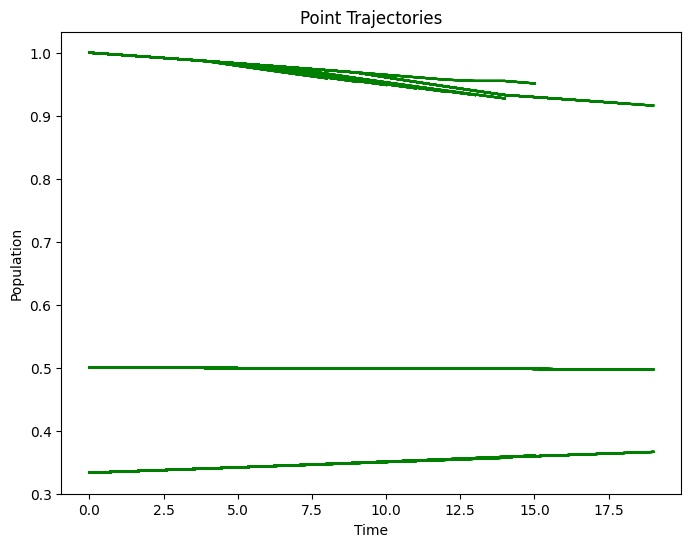

2023-12-29 16:25:39,163 - funman.api.run - INFO - Creating plot of parameter space: ./out/0e140512-2416-4ef9-9162-7fdbbf4e44cb_parameter_space.png


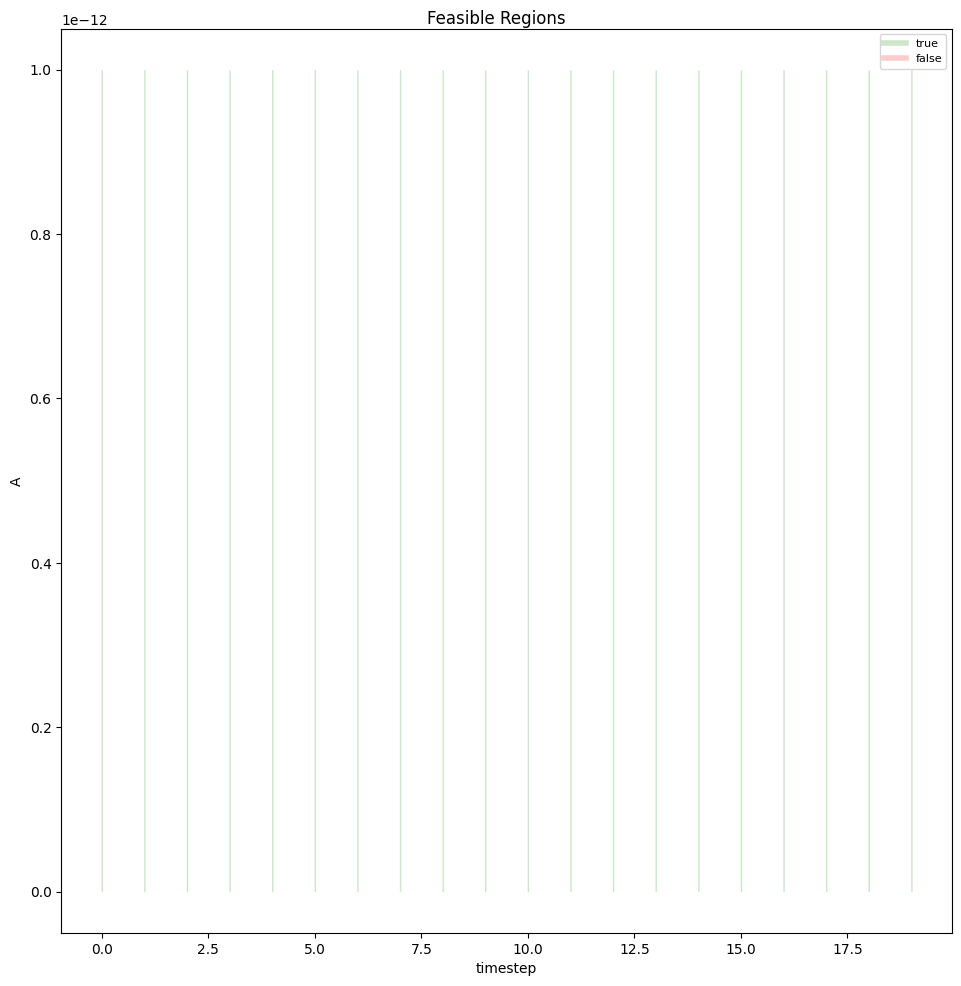

2023-12-29 16:25:39,928 - funman.server.worker - INFO - Completed work on: 0e140512-2416-4ef9-9162-7fdbbf4e44cb
2023-12-29 16:25:49,439 - funman.server.worker - INFO - Worker.stop() acquiring state lock ....
2023-12-29 16:25:49,497 - funman.server.worker - INFO - FunmanWorker exiting...
2023-12-29 16:25:49,503 - funman.server.worker - INFO - Worker.stop() completed.
2023-12-29 16:25:49,505 - /home/danbryce/funman/auxiliary_packages/funman_demo/src/funman_demo/plot.py - INFO - ********************************************************************************
2023-12-29 16:25:49,507 - /home/danbryce/funman/auxiliary_packages/funman_demo/src/funman_demo/plot.py - INFO - ********************************************************************************
2023-12-29 16:25:49,509 - /home/danbryce/funman/auxiliary_packages/funman_demo/src/funman_demo/plot.py - INFO - * Analysis Summary 
2023-12-29 16:25:49,511 - /home/danbryce/funman/auxiliary_packages/funman_demo/src/funman_demo/plot.py - INFO - *

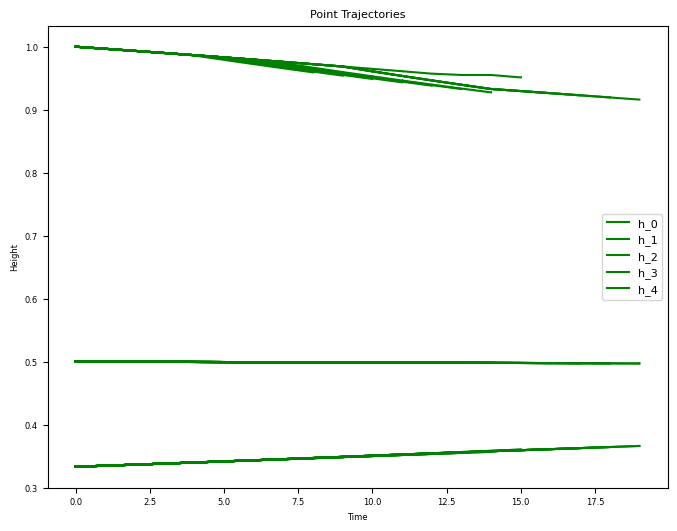

In [2]:
# 1x5 model

MODEL_PATH = os.path.join(EXAMPLE_DIR, f"halfar_1x5_0_boundary.json")


# Create constraint pos_i on the height h at each location i
# pos_i: 0 <= h_i < 1.01, for i in [0, 4]
num_disc = 5
variables = [f"h_{d}" for d in range(num_disc)]
height_bounds = [
            {"name": f"pos_{i}",
         "variable": i,
         "interval": {"lb": 0, "ub": 1.01}
         }
    for i in variables
]

# Create request for the analysis
# structure_parameters: timepoints to evaluate 
# parameters: A, dt
# constraints: height bounds (above), slope on boundaries is well-formed
# config: uses defaults

request_dict = {
    "structure_parameters": [
        {
            "name": "schedules",
            "schedules": [
                {"timepoints": range(0,20, 1)}
            ],
        },
        
    ],
    "parameters":[
        {"name": "A",
         "label":"all",
         "interval": {"lb":1e-20, "ub":1e-12}
         },
        {"name": "dt",
         "label":"any",
         "interval": {"lb":20, "ub":20}
         }
    ],
    "constraints": height_bounds + 
    [
        {"name": "LHS_slope",
            "variables": ["h_1", "h_0"],
            "weights": [1, -1],
            "additive_bounds": {"lb": 0},
            "timepoints": {"lb": 0}
        }, 
        {"name": "RHS_slope",
            "variables": ["h_3", "h_4"],
            "weights": [1, -1],
            "additive_bounds": {"lb": 0},
            "timepoints": {"lb": 0}
        }
    #  {"name": "melt_h_5",
    #      "variable": "h_5",
    #      "interval": {"lb": 0, "ub": .8},
    #      "timepoints": {"lb": 5}
    #     },

        ],
    "config": {
        # "use_compartmental_constraints": False,
        # "normalization_constant": 1.0,
        # "tolerance": 1e-2,
        # "verbosity": 20,
        # "dreal_mcts": False,
        # "dreal_precision": 0.1,
        # "save_smtlib": "./out",
        # "substitute_subformulas": False,
        # "series_approximation_threshold": None,
        # "dreal_log_level": "info",
        # "profile": False,
    },
}


# Use request_dict
results = Runner().run(
    MODEL_PATH,
    request_dict,
    description="Halfar 1x5 Demo",
    case_out_dir="./out",
    dump_plot=True,
    parameters_to_plot=["A", "timestep"],
    point_plot_config={
        # "variables":variables, 
        "label_marker":{"true":",", "false": ","},  
        # "xlabel":"Time", 
        # "ylabel":"Height", 
        # "legend":variables,
        # "label_color":{"true": "g", "false":"r"}
        },
    # num_points=None,
)

summarize_results(variables, results)

In [6]:
import matplotlib.pyplot as plt
h, dh = plot_spatial_timeseries(results)
plt.close()
display(h)
plt.close()
display(dh)

In [15]:
# Use a five point 2d model 


MODEL_PATH = os.path.join("../", "resources/amr/halfar/halfar_5x5_0_boundary.json")

# Create constraint pos_i_j on the height h at each location i,j
# pos_i_j: 0 <= h_i_j < 1.01, for i in [0, 4] for j in [0, 4]
num_disc = 5
variables = [f"h_{d1}_{d2}" for d1 in range(num_disc) for d2 in range(num_disc)]
height_bounds = [
            {"name": f"pos_{i}",
         "variable": i,
         "interval": {"lb": 0, "ub": 1.01}
         }
    for i in variables
]

pos_slope = [
    {"name": f"LHS_slope_0_{i}",
            "variables": [f"h_1_{i}", f"h_0_{i}"],
            "weights": [1, -1],
            "additive_bounds": {"lb": 0},
            "timepoints": {"lb": 0}
    } 
    for i in range(1, num_disc-1)
] + [
    {"name": f"LHS_slope_1_{i}",
            "variables": [f"h_{i}_1", f"h_{i}_0"],
            "weights": [1, -1],
            "additive_bounds": {"lb": 0},
            "timepoints": {"lb": 0}
    } 
    for i in range(1, num_disc-1)
]

neg_slope = [
       {"name": f"RHS_slope_0_{i}",
            "variables": [f"h_{num_disc-2}_{i}", f"h_{num_disc-1}_{i}"],
            "weights": [1, -1],
            "additive_bounds": {"lb": 0},
            "timepoints": {"lb": 0}
        }
        for i in range(1, num_disc-1)
] + [
    {"name": f"RHS_slope_1_{i}",
            "variables": [f"h_{i}_{num_disc-2}", f"h_{i}_{num_disc-1}"],
            "weights": [1, -1],
            "additive_bounds": {"lb": 0},
            "timepoints": {"lb": 0}
        }
        for i in range(1, num_disc-1)
]

# Create request for the analysis
# structure_parameters: timepoints to evaluate 
# parameters: A, dt
# constraints: height bounds (above), slope on boundaries is well-formed
# config: uses defaults

request_dict = {
    "structure_parameters": [
        {
            "name": "schedules",
            "schedules": [
                {"timepoints": range(0,10, 1)}
            ],
        },
        
    ],
    "parameters":[
        {"name": "A",
         "label":"any",
        #  "interval": {"lb":1e-20, "ub":1e-12}}
         "interval": {"lb":1e-20, "ub":1e-12}}
        ,
        {"name": "dt",
         "label":"any",
         "interval": {"lb":50, "ub":50}
         }
    ],
    "constraints": height_bounds + pos_slope + neg_slope +
    [
        
     


    #  {"name": "melt_h_5",
    #      "variable": "h_5",
    #      "interval": {"lb": 0, "ub": .8},
    #      "timepoints": {"lb": 5}
    #     },

        ],
    "config": {
        # "use_compartmental_constraints": False,
        # "normalization_constant": 1.0,
        # "tolerance": 1e-3,
        "verbosity": 10,
        # "dreal_mcts": False,
        # "dreal_precision": 1,
        # "save_smtlib": "./out",
        # "substitute_subformulas": False,
        # "series_approximation_threshold": None,
        # "dreal_log_level": "info",
        # "profile": False,
    },
}


# Use request_dict
results = Runner().run(
    MODEL_PATH,
    request_dict,
    # REQUEST_PATH,
    description="Halfar 5x5 demo",
    case_out_dir="./out",
    dump_plot=True,
    parameters_to_plot=["A", "timestep"],
    point_plot_config={
        # "variables":variables, 
        "label_marker":{"true":",", "false": ","},  
        # "xlabel":"Time", "ylabel":"Height", "legend":variables,"label_color":{"true": "g", "false":"r"}
        },
    # num_points=None,
    
)

summarize_results(variables, results)




2023-12-29 17:07:12,338 - funman.server.worker - INFO - FunmanWorker running...
[50.00000, 50.00000) has equal lower and upper bounds, so assuming the upper bound is closed.  (I.e., [lb, ub) is actually [lb, ub])
2023-12-29 17:07:12,346 - funman.server.worker - INFO - Starting work on: 4421bd8d-a6b7-454d-b3f6-ae4ca19b2336
2023-12-29 17:07:12,348 - funman.scenario.scenario - WARNING - Warning: The scenario is not normalized!
2023-12-29 17:07:14,359 - funman.api.run - INFO - Dumping results to ./out/4421bd8d-a6b7-454d-b3f6-ae4ca19b2336.json
2023-12-29 17:07:24,407 - funman.api.run - INFO - Dumping results to ./out/4421bd8d-a6b7-454d-b3f6-ae4ca19b2336.json
2023-12-29 17:07:28,872 - /home/danbryce/funman/src/funman/search/smt_check.py - DEBUG - Solving schedule: timepoints=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
2023-12-29 17:07:28,873 - funman_dreal.solver - DEBUG - Created new Solver ...
2023-12-29 17:07:28,902 - /home/danbryce/funman/src/funman/translate/petrinet.py - DEBUG - Encoding step: 0 to

In [16]:
import matplotlib.pyplot as plt
h, dh = plot_spatial_timeseries(results)
plt.close()
display(h)
plt.close()
display(dh)

2023-12-29 17:10:49,157 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7fff91f21c40>
2023-12-29 17:10:49,379 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7fff8f446970>
2023-12-29 17:10:49,654 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7fffcddc1a00>
2023-12-29 17:10:50,225 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7fff8edd2ac0>
2023-12-29 17:10:50,509 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7fff8eada970>
2023-12-29 17:10:50,778 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7fffae50e1f0>
2023-12-29 17:10:51,048 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7fffce0b0790>
2023-12-29 17:10:51,350 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7fff8e9c3b50>
2023-12-29 17:10:51,628 

2023-12-22 22:35:03,139 - matplotlib.animation - INFO - Animation.save using <class 'matplotlib.animation.HTMLWriter'>
2023-12-22 22:35:03,154 - matplotlib.animation - INFO - figure size in inches has been adjusted from 6.4 x 4.8 to 6.4 x 4.800000000000001
2023-12-22 22:35:03,157 - matplotlib.animation - DEBUG - frame size in pixels is 640 x 480
2023-12-22 22:35:03,418 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7f6b356d7f40>
2023-12-22 22:35:04,037 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7f6b356136d0>
2023-12-22 22:35:04,646 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7f6b355d0f10>
2023-12-22 22:35:05,241 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7f6b354dea60>
2023-12-22 22:35:05,866 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7f6b3546ba60>
2023-12-22 22:35:07,125 - matplotlib.color

h                                        
               0         1         2         3         4
time                                                    
0.0  0  0.333333  0.333333  0.333333  0.333333  0.333333
     1  0.333333  0.500000  0.500000  0.500000  0.333333
     2  0.333333  0.500000  1.000000  0.500000  0.333333
     3  0.333333  0.500000  0.500000  0.500000  0.333333
     4  0.333333  0.333333  0.333333  0.333333  0.333333
1.0  0  0.333333  0.333333  0.333251  0.333333  0.333333
     1  0.333333  0.500009  0.500007  0.500009  0.333333
     2  0.333251  0.500007  1.000328  0.500007  0.333251
     3  0.333333  0.500009  0.500007  0.500009  0.333333
     4  0.333333  0.333333  0.333251  0.333333  0.333333
2.0  0  0.333333  0.333333  0.333169  0.333333  0.333333
     1  0.333333  0.500018  0.500014  0.500018  0.333333
     2  0.333169  0.500014  1.000658  0.500014  0.333169
     3  0.333333  0.500018  0.500014  0.500018  0.333333
     4  0.333333  0.333333  0.333169  0.333333  0.333333
3.0  0  0.333333  0.333334  0.333086  0.333334  0.333333
     1  0.333334  0.500027  0.500021  0.500027  0.333334
     2  0.333086  0.500021  1.000989  0.500021  0.333086
     3  0.333334  0.500027  0.500021  0.500027  0.333334
     4  0.333333  0.333334  0.333086  0.333334  0.333333
4.0  0  0.333333  0.333334  0.333003  0.333334  0.333333
     1  0.333334  0.500036  0.500029  0.500036  0.333334
     2  0.333003  0.500029  1.001321  0.500029  0.333003
     3  0.333334  0.500036  0.500029  0.500036  0.333334
     4  0.333333  0.333334  0.333003  0.333334  0.333333
5.0  0  0.333333  0.333334  0.332920  0.333334  0.333333
     1  0.333334  0.500046  0.500036  0.500046  0.333334
     2  0.332920  0.500036  1.001654  0.500036  0.332920
     3  0.333334  0.500046  0.500036  0.500046  0.333334
     4  0.333333  0.333334  0.332920  0.333334  0.333333
6.0  0  0.333333  0.333334  0.332836  0.333334  0.333333
     1  0.333334  0.500055  0.500043  0.500055  0.333334
     2  0.332836  0.500043  1.001989  0.500043  0.332836
     3  0.333334  0.500055  0.500043  0.500055  0.333334
     4  0.333333  0.333334  0.332836  0.333334  0.333333
7.0  0  0.333333  0.333334  0.332752  0.333334  0.333333
     1  0.333334  0.500064  0.500050  0.500064  0.333334
     2  0.332752  0.500050  1.002325  0.500050  0.332752
     3  0.333334  0.500064  0.500050  0.500064  0.333334
     4  0.333333  0.333334  0.332752  0.333334  0.333333
8.0  0  0.333333  0.333334  0.332668  0.333334  0.333333
     1  0.333334  0.500073  0.500057  0.500073  0.333334
     2  0.332668  0.500057  1.002663  0.500057  0.332668
     3  0.333334  0.500073  0.500057  0.500073  0.333334
     4  0.333333  0.333334  0.332668  0.333334  0.333333
9.0  0  0.333333  0.333334  0.332583  0.333334  0.333333
     1  0.333334  0.500082  0.500064  0.500082  0.333334
     2  0.332583  0.500064  1.003001  0.500064  0.332583
     3  0.333334  0.500082  0.500064  0.500082  0.333334
     4  0.333333  0.333334  0.332583  0.333334  0.333333

2023-12-22 22:35:12,439 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7f6add2201c0>


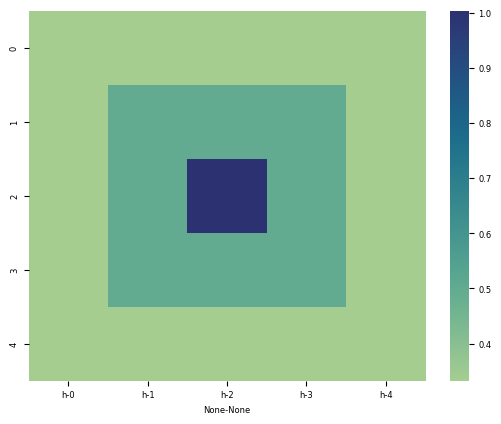

In [18]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML
import numpy as np
import pandas as pd
from sklearn import preprocessing

df = results.dataframe(points=[results.parameter_space.true_points()[-1]])
steps=len(df)
df = df.drop(columns=["A", "id", "label"])


# x = df.values #returns a numpy array
# min_max_scaler = preprocessing.MinMaxScaler()
# standard_scaler = preprocessing.StandardScaler()
# x_scaled = min_max_scaler.fit_transform(x)
# # x_scaled = standard_scaler.fit_transform(x)
# df = pd.DataFrame(x_scaled, columns =df.columns)



df.columns = df.columns.str.split("_", expand=True)
df = df.stack([1])



def animate_heat_map(my_df, frames):
    fig = plt.figure()

    data = my_df.loc[0,:]
    vmin = my_df.min().min()
    vmax = my_df.max().max()
    # ax = sns.heatmap(data, vmin=0, vmax=1)

    # def init():
    #     plt.clf()
    #     ax = sns.heatmap(data, vmin=0, vmax=1)

    def animate(i):
        plt.clf()
        data = my_df.loc[i,:]
        ax = sns.heatmap(data, vmin=vmin, vmax=vmax, cmap="crest")

    anim = animation.FuncAnimation(fig, animate, #init_func=init, 
    interval=1000, frames=frames)

    return anim
    


anim = animate_heat_map(df, steps)
HTML(anim.to_jshtml())

df

In [2]:
# Advection Model

num_disc = 5

# MODEL_PATH = os.path.join("..", f"resources/amr/advection_1d/advection_1d_forward.json")
MODEL_PATH = os.path.join("..", f"resources/amr/advection_1d/advection_1d_backward.json")
# MODEL_PATH = os.path.join("..", f"resources/amr/advection_1d/advection_1d_centered.json")

height_bounds = [
            {"name": f"pos_u_{i}",
         "variable": f"u_{i}",
         "interval": {"lb": 0}
         }
    for i in range(num_disc)
]

request_dict = {
    "structure_parameters": [
        {
            "name": "schedules",
            "schedules": [
                {"timepoints": range(0, 4, 1)}
            ],
        },
        
    ],
    "parameters":[
        {"name": "dx",
         "label":"any",
        #  "interval": {"lb":1e-18, "ub":1e-14}}
        "interval": {"lb":1e-1, "ub":1}},
        {"name": "a",
         "label":"any",
        #  "interval": {"lb":1e-18, "ub":1e-14}}
        "interval": {"lb":-1, "ub":1}}
    ],
    "constraints": 
    height_bounds + 
    [

        # 0 <= dx - a
        # a <= dx
        # {"name": "dx_gte_a",
        #     "variables": ["dx", "a"],
        #     "weights": [1, -1],
        #     "additive_bounds": {"lb": 0},
        #     # "timepoints": {"lb": 0}
        # }, 
    #     {"name": "RHS_slope",
    #         "variables": ["h_8", "h_9"],
    #         "weights": [1, -1],
    #         "additive_bounds": {"lb": 0},
    #         "timepoints": {"lb": 0}
    #     }


    #  {"name": "melt_h_5",
    #      "variable": "h_5",
    #      "interval": {"lb": 0, "ub": .8},
    #      "timepoints": {"lb": 5}
    #     },

        ],
    "config": {
        # "use_compartmental_constraints": False,
        "normalization_constant": 1.0,
        "tolerance": 1e-2,
        "verbosity": 5,
        # "dreal_mcts": True,
        # "dreal_precision": 1,
        "save_smtlib": "./out",
        # "substitute_subformulas": False,
        # "series_approximation_threshold": None,
        "dreal_log_level": "trace",
        # "profile": False,
    },
}
variables = [f"u_{d}" for d in range(num_disc)]

# Use request_dict
results = Runner().run(
    MODEL_PATH,
    request_dict,
    # REQUEST_PATH,
    description="Halfar demo",
    case_out_dir="./out",
    dump_plot=True,
    parameters_to_plot=["a", "dx", "timestep"],
    point_plot_config={"variables":variables, "label_marker":{"true":",", "false": ","},  "xlabel":"Time", "ylabel":"Height", "legend":variables
    #,"label_color":{"true": "g", "false":"r"}
    },
    num_points=None
)

summarize_results(variables, results)




2023-12-16 18:58:50,629 - /home/danbryce/funman/src/funman/search/smt_check.py - DEBUG - Solving schedule: timepoints=[0, 1, 2, 3]
2023-12-16 18:58:50,636 - funman_dreal.solver - DEBUG - Created new Solver ...
[debug] [20231216 18:58:50.635226] SatSolver::Set Default Phase Jeroslow-Wang
[debug] [20231216 18:58:50.636558] ContextImpl::SetLogic(QF_NRA)
2023-12-16 18:58:50,645 - /home/danbryce/funman/src/funman/translate/petrinet.py - DEBUG - Encoding step: 0 to 1
2023-12-16 18:58:50,708 - /home/danbryce/funman/src/funman/translate/petrinet.py - DEBUG - Encoding step: 1 to 2
2023-12-16 18:58:50,748 - /home/danbryce/funman/src/funman/translate/petrinet.py - DEBUG - Encoding step: 2 to 3
2023-12-16 18:58:50,786 - funman_dreal.solver - TRACE - Push()
2023-12-16 18:58:50,792 - funman_dreal.solver - TRACE - Assert(((assume_pos_u_0 & assume_pos_u_1 & assume_pos_u_2 & assume_pos_u_3 & assume_pos_u_4) & (((assume_pos_u_0 <-> (0.0 <= u_0_0)) & (assume_pos_u_1 <-> (0.0 <= u_1_0)) & (assume_pos_u_2 

In [ ]:
# Centered

#         a   dx  id label      u_0       u_1       u_2        u_3       u_4
# time                                                                      
# 0.0   0.5  0.1   0  true   0.1000    0.5000   1.00000    0.50000   0.10000
# 1.0   0.5  0.1   0  true  -1.1500   -1.7500   1.00000    3.00000   1.35000
# 2.0   0.5  0.1   0  true   3.2250   -7.1250 -10.87500    5.50000   8.85000
# 3.0   0.5  0.1   0  true  21.0375   28.1250 -42.43750  -21.68750  22.60000
# 4.0   0.5  0.1   0  true -49.2750  186.8125  82.09375 -127.78125 -31.61875

# Forward 

#         a   dx  id label     u_0     u_1    u_2    u_3    u_4
# time                                                         
# 0.0   0.5  0.1   0  true     0.1     0.5    1.0    0.5    0.1
# 1.0   0.5  0.1   0  true    -1.9    -2.0    3.5    2.5    0.6
# 2.0   0.5  0.1   0  true    -1.4   -29.5    8.5   12.0    3.6
# 3.0   0.5  0.1   0  true   139.1  -219.5   -9.0   54.0   21.6
# 4.0   0.5  0.1   0  true  1932.1 -1272.0 -324.0  216.0  129.6


# Backward 

#         a   dx  id label   u_0           u_1    u_2    u_3    u_4
# time                                                             
# 0.0   0.5  0.1   0  true   0.1  5.000000e-01    1.0    0.5    0.1
# 1.0   0.5  0.1   0  true  -0.4 -1.500000e+00   -1.5    3.0    2.6
# 2.0   0.5  0.1   0  true   1.6  4.000000e+00   -1.5  -19.5   17.6
# 3.0   0.5  0.1   0  true  -6.4 -8.000000e+00   26.0   70.5  -79.9
# 4.0   0.5  0.1   0  true  25.6 -1.243450e-14 -144.0 -152.0  272.6